# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importing the used libraries

In [2]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Creating initial database with all datasets provided in kagle
    -> Year and month columns were added to facilitate analysis


In [3]:
months = {
    "jan": 1,
    "fev": 2,
    "mar": 3,
    "abr": 4,
    "mai": 5,
    "jun": 6,
    "jul": 7,
    "ago": 8,
    "set": 9,
    "out": 10,
    "nov": 11,
    "dez": 12
}

path_datasets = pathlib.Path('dataset')
data = []

for dataset in path_datasets.iterdir():
    year = dataset.name[-8:]
    year = int(year.replace('.csv', ''))
    month_name = dataset.name[:3]
    month = months[month_name]
    df = pd.read_csv(path_datasets / dataset.name)
    df['year'] = year
    df['month'] = month
    data.append(df)

data_airbnb = pd.concat(data)
display(data_airbnb.head())

C:\Users\eduar\AppData\Local\Temp\ipykernel_16364\1994210354.py:24: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_datasets / dataset.name)
C:\Users\eduar\AppData\Local\Temp\ipykernel_16364\1994210354.py:24: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_datasets / dataset.name)
C:\Users\eduar\AppData\Local\Temp\ipykernel_16364\1994210354.py:24: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_datasets / dataset.name)
C:\Users\eduar\AppData\Local\Temp\ipykernel_16364\1994210354.py:24: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_datasets / dataset.name)
C:\Users\eduar\AppData\Local\Temp\ipykernel_16364\1994210354.py:24: DtypeWarning: Columns (61,62,94) have mixed t

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyzing unnecessary columns

Exporting a smaller file to analyze which columns are disposable and reduce the size of the database for better code eficiency

In [4]:
# print(list(data_airbnb.columns))
data_airbnb.head(1000).to_csv('data_airbnb_sample.csv', sep = ',', index = False)

### Type of irrelavant information to be discarted after analysis
1 - IDs

2 - Links

3 - Information related to the scrapping used to obtain the information

4 - Columns with repetitive information (E.g: "last_scraped" which gives us the year and month which we already added)

5 - Free text columns. No key word analysis will be done for this project. (E.g: Host and listing descriptions)

6 - Empty or almost empty columns

In [80]:
analyzed_columns = ['host_response_time','host_response_rate','host_is_superhost','host_total_listings_count','host_identity_verified','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','year','month']
airbnb_df = data_airbnb[analyzed_columns]
display(airbnb_df.head())

,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,year,month
0,NaN,NaN,f,1.0,t,-22.946854,-43.182737,Apartment,Entire home/apt,4,...,9.0,9.0,9.0,f,f,strict_14_with_grace_period,f,f,2018,4
1,within an hour,100%,t,2.0,f,-22.965919,-43.178962,Condominium,Entire home/apt,5,...,10.0,9.0,9.0,t,f,strict,f,f,2018,4
2,within an hour,100%,f,1.0,t,-22.985698,-43.201935,Apartment,Entire home/apt,2,...,10.0,10.0,9.0,f,f,strict,f,f,2018,4
3,within an hour,100%,f,3.0,t,-22.977117,-43.190454,Apartment,Entire home/apt,3,...,10.0,10.0,9.0,f,f,strict,t,t,2018,4
4,within an hour,100%,t,1.0,t,-22.983024,-43.214270,Apartment,Entire home/apt,3,...,10.0,10.0,9.0,t,f,strict,f,f,2018,4


### Processing missing values (NaN)

    -> Columns which had over 300,000 missing values were excluded from analysis due to the high number of NaN given the size of the sample (~=900,000)
    -> For columns with a low number of missing values, the lines containing one or more columns with NaN were excluded from analysis.

In [81]:
for column in airbnb_df:
    if airbnb_df[column].isnull().sum() > 300_000:
        airbnb_df = airbnb_df.drop(column, axis=1)
airbnb_df = airbnb_df.dropna()

### Verifying the type of data in each column

In [82]:
print(airbnb_df.dtypes)
print('-'*40)
print(airbnb_df.iloc[0])
# price -> float
# extra_people -> float
# host_total_listing_counts -> int
# bedrooms -> int
# beds -> int

host_is_superhost                    object
host_total_listings_count           float64
host_identity_verified               object
latitude                            float64
longitude                           float64
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
price                                object
guests_included                       int64
extra_people                         object
minimum_nights                        int64
maximum_nights                        int64
number_of_reviews                     int64
instant_bookable                     object
is_business_travel_ready             object
cancellation_policy                  object
require_guest_profile_picture   

    -> After analysing the types of data we can observe that price and extra_people are treated as string objects due to the "$" sign and the "," thousands separator. These will be converted to float32 types as they are prices that are the main subject of our analysis.
    -> Other columns that may have been misrepresented as floats will be converted into int variables.
    -> The numbers were converted to float or int 32 due to the high number of data aiming to improve the code eficiency.

In [83]:
airbnb_df['price'] = airbnb_df['price'].str.replace('$', '')
airbnb_df['price'] = airbnb_df['price'].str.replace(',', '')
airbnb_df['price'] = airbnb_df['price'].astype(np.float32)
airbnb_df['extra_people'] = airbnb_df['extra_people'].str.replace('$', '')
airbnb_df['extra_people'] = airbnb_df['extra_people'].str.replace(',', '')
airbnb_df['extra_people'] = airbnb_df['extra_people'].astype(np.float32)
airbnb_df[['host_total_listings_count', 'bedrooms', 'beds']] = airbnb_df[['host_total_listings_count', 'bedrooms', 'beds']].astype(np.int32)
float64_cols = list(airbnb_df.select_dtypes(include='float64'))
airbnb_df[float64_cols] = airbnb_df[float64_cols].astype(np.float32)
int64_cols = list(airbnb_df.select_dtypes(include='int64'))
airbnb_df[int64_cols] = airbnb_df[int64_cols].astype(np.int32)
print(airbnb_df.dtypes)

host_is_superhost                    object
host_total_listings_count             int32
host_identity_verified               object
latitude                            float32
longitude                           float32
property_type                        object
room_type                            object
accommodates                          int32
bathrooms                           float32
bedrooms                              int32
beds                                  int32
bed_type                             object
amenities                            object
price                               float32
guests_included                       int32
extra_people                        float32
minimum_nights                        int32
maximum_nights                        int32
number_of_reviews                     int32
instant_bookable                     object
is_business_travel_ready             object
cancellation_policy                  object
require_guest_profile_picture   

### Exploratory analysis and processing outliers

<Axes: >

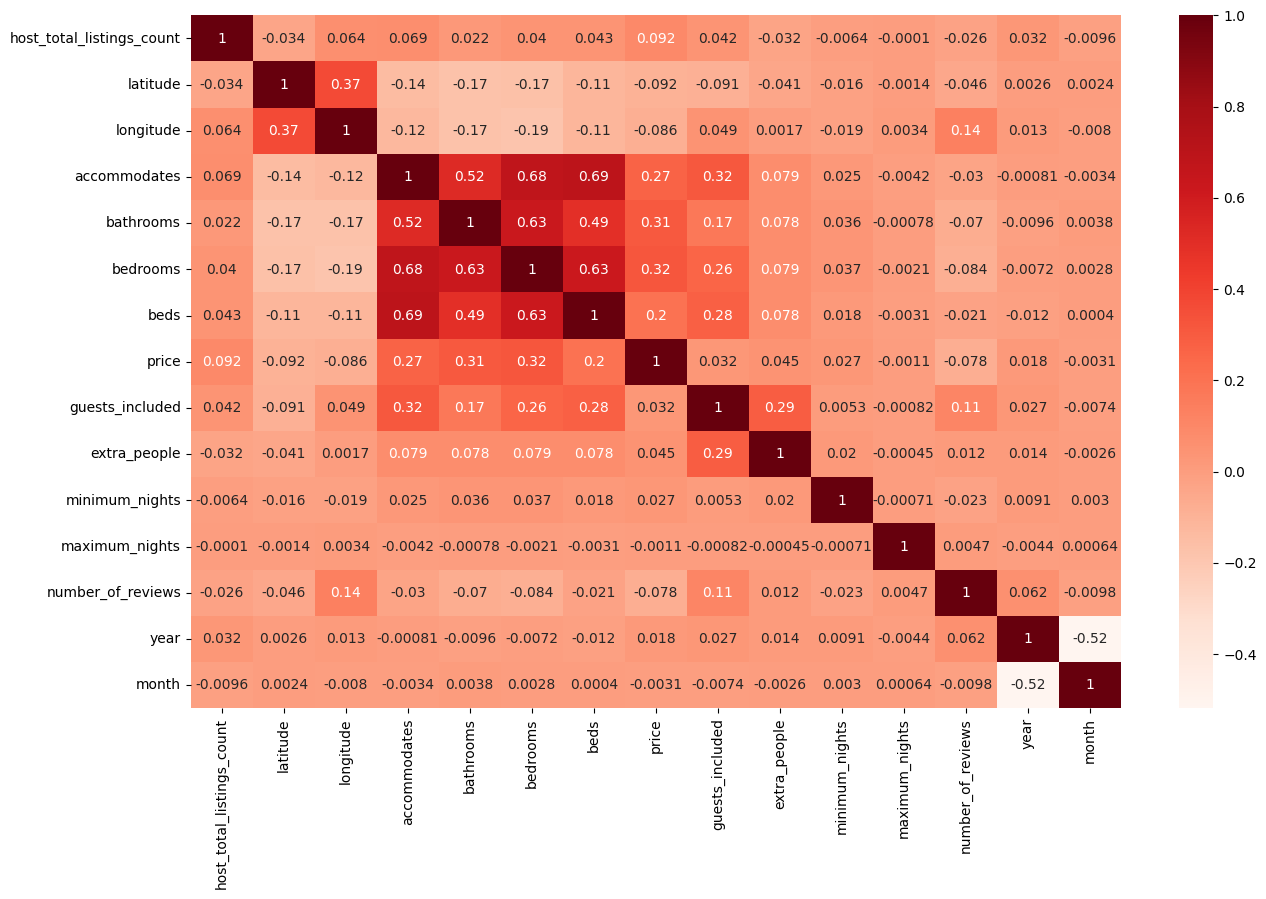

In [84]:
# Checking the correlation between the cols to see if any strong correlation will be removed
plt.figure(figsize=(15,9))
sns.heatmap(airbnb_df.corr(numeric_only=True), annot=True, cmap='Reds')
# As the correlations are't too strong, all cols will be manteined for this analysis.

In [85]:
def lims(col):
    '''Calculates the superior and inferior limit to identify outliers based on the third and first quartile, respectfully, times the amplitude which is the difference between the quartiles

    Parameters:
        col (str): pd.DataFrame[column]

    Returns:
        inferior_limit (float): first quartile times amplitude 
        superior_limit (float): third quartile times amplitude
    '''
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    amplitude = q3 - q1
    superior_limit = q3 + 1.5 * amplitude
    inferior_limit = q1 - 1.5 * amplitude
    if inferior_limit < 0:
        inferior_limit = -1
    return inferior_limit, superior_limit

def remove_outliers(df, col_name):
    '''Removes the outliers from the DataFrame taking in consideration the limits defined in the lims function

    Parameters:
        df (str): pd.Dataframe
        col_name (str): pd.DataFrame column name as string 

    Returns:
        df (pd.DataFrame): pd.DataFrame without outliers
        rows_removed (int): number of rows removed from the DataFrame
    '''
    row_count = df.shape[0]
    inferior_limit, superior_limit = lims(df[col_name])
    df = df.loc[(df[col_name] >= inferior_limit) & (df[col_name] <= superior_limit), :]
    row_count_new = df.shape[0]
    rows_removed = row_count - row_count_new
    return df, rows_removed

def box_diagram(col):
    '''Creates two box diagrams for data visualization

    Parameters:
        col (str): pd.DataFrame[column]

    Returns:
        figure1: box diagram for outliers visualization
        figure2: box diagram zoomed in without outliers
    '''
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.boxplot(x=col, ax = ax1)
    sns.boxplot(x=col, ax = ax2)
    ax2.set_xlim(lims(col))

def histogram(col):
    '''Creates a histogram for data visualization

    Parameters:
        col (str): pd.DataFrame[column]

    Returns:
        figure: histogram for data distribution evaluation
    '''
    plt.figure(figsize=(15,5))
    sns.histplot(airbnb_df, x=col, stat='density')

def bar_graph(col):
    '''Creates a bar graph for data visualization

    Parameters:
        col (str): pd.DataFrame[column]

    Returns:
        figure: bar graph for data distribution evaluation inside the limits without outliers
    '''
    plt.figure(figsize=(15,5))
    bars = plt.bar(col.value_counts().index, col.value_counts())
    plt.bar_label(bars, labels=col.value_counts(), padding=3, fontsize=10, fontweight='bold')
    plt.xticks(col.value_counts().index)
    plt.xlim(lims(col))

def text_bar_graph(col_name):
    '''Creates a bar graph for data visualization in text columns

    Parameters:
        col_name (str): pd.DataFrame column name as string

    Returns:
        figure: bar graph for data distribution evaluation inside the limits without outliers
    '''
    plt.figure(figsize=(15,5))
    sns.countplot(data = airbnb_df, x = col_name).tick_params(rotation = 90)


### price analysis
    -> Outliers were removed in this case due to the model objective to predict the value of accomodations for a generic person, not taking in account high end apartments/houses

(-1, 1276.0)
87282


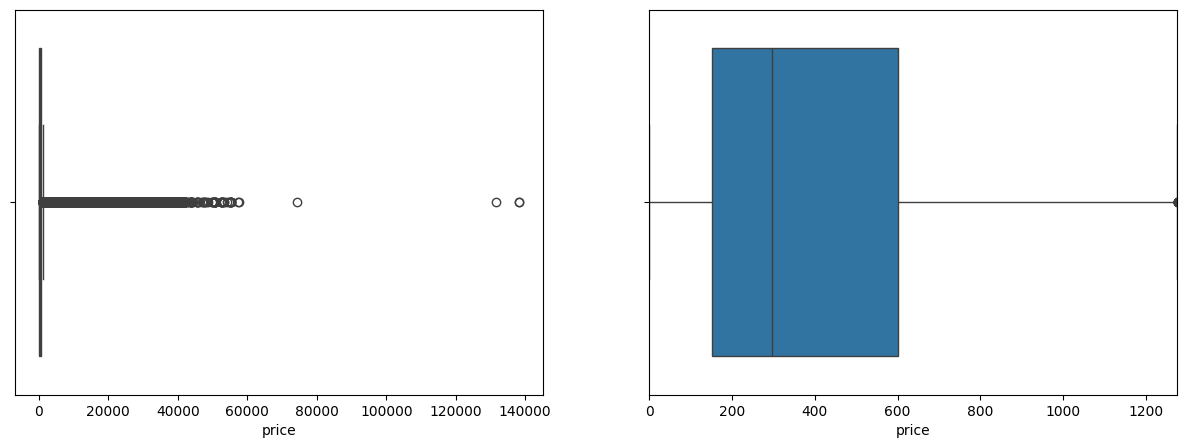

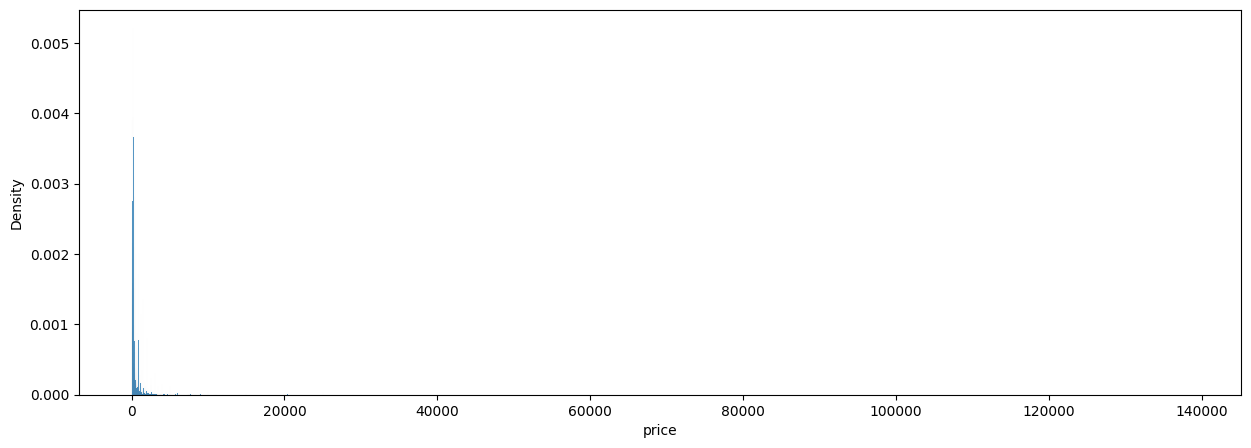

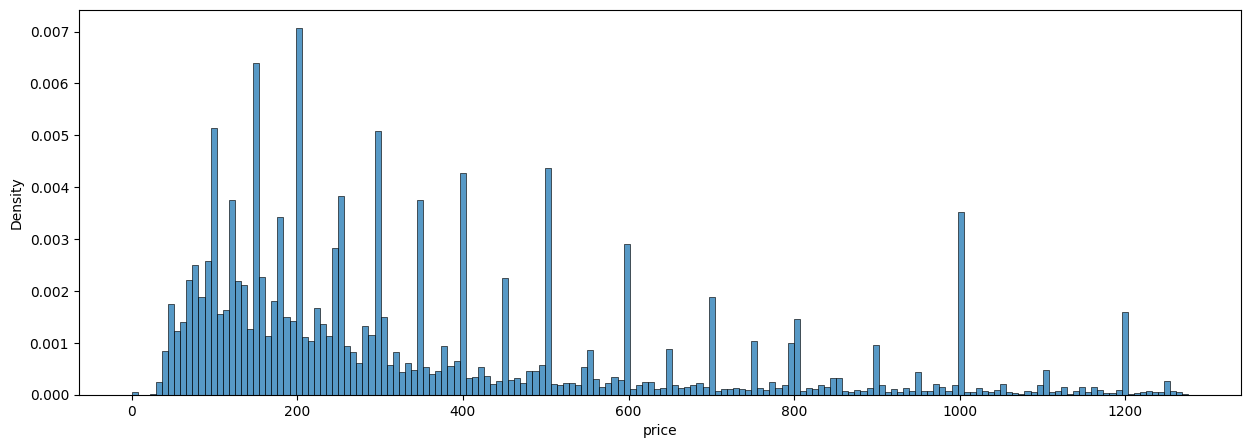

In [86]:
print(lims(airbnb_df['price']))
box_diagram(airbnb_df['price'])
histogram(airbnb_df['price'])
airbnb_df, rows_removed = remove_outliers(airbnb_df, 'price')
print(rows_removed)
histogram(airbnb_df['price'])

## extra_people analysis
    -> In this case, outliers are being removed at first due to the fact that it doesn't remove a large number of data given the size of our sample.
    As the price of extra_people is relatively low, this column may be totaly removed from analysis in the future. On the other hand, if outliers prices of extra people impact on the type of housing analyzed, it can be included again in the model afterwards.

(-1, 125.0)
59194


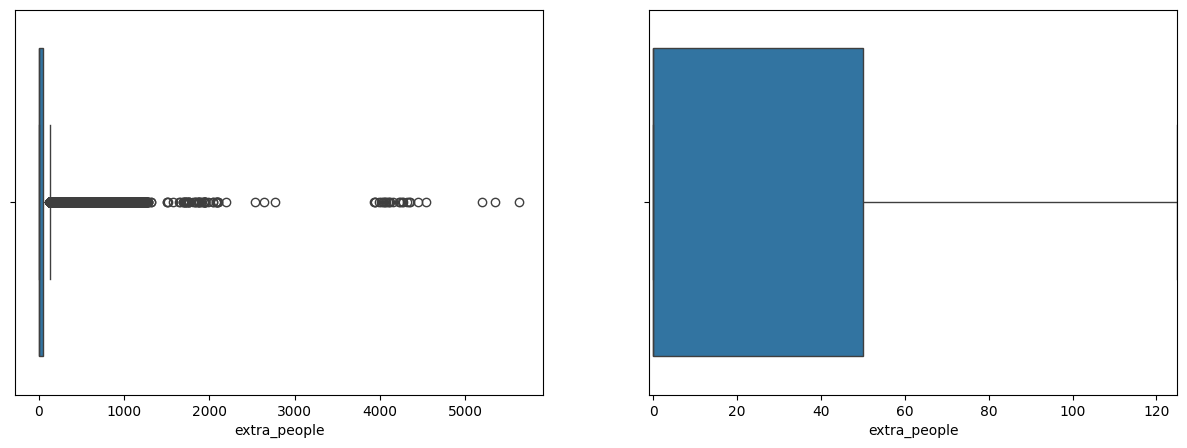

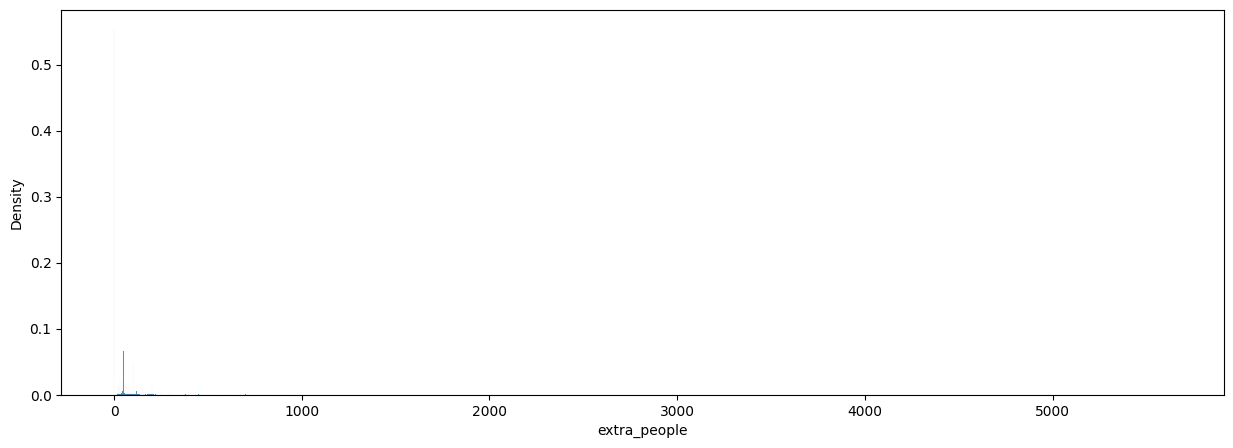

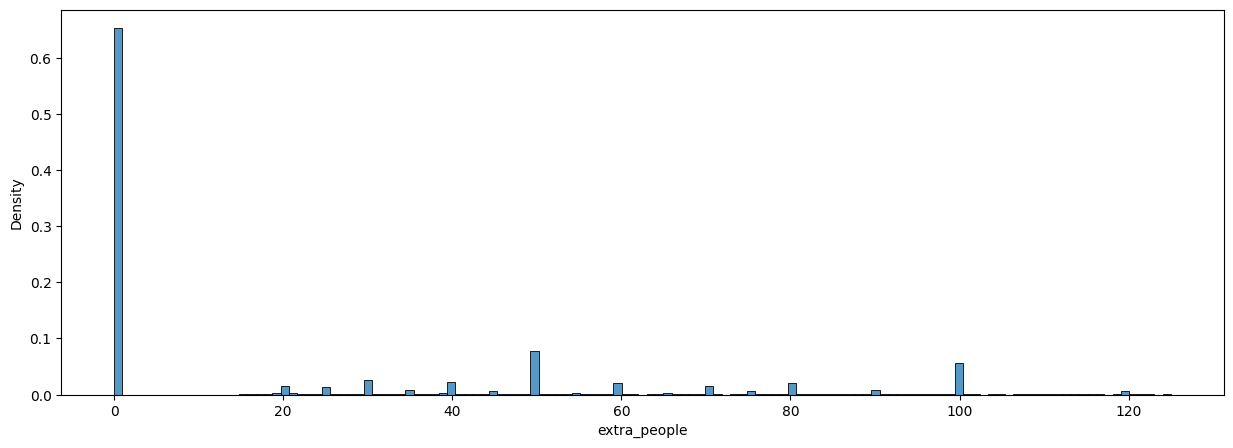

In [87]:
print(lims(airbnb_df['extra_people']))
box_diagram(airbnb_df['extra_people'])
histogram(airbnb_df['extra_people'])
airbnb_df, rows_removed = remove_outliers(airbnb_df, 'extra_people')
print(rows_removed)
histogram(airbnb_df['extra_people'])

### host_total_listings_count analysis
    -> Outliers were not removed from this model due to fact that hosts with a higher number of listings are probably companies that work with housing rental, which is a feature to be taken in considearation due to the different type of negotiation.

(-1, 6.0)


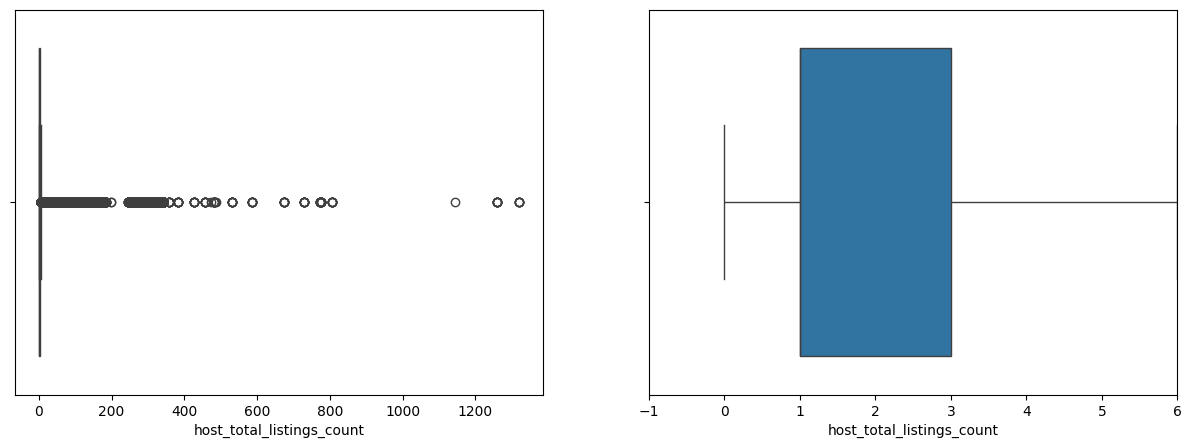

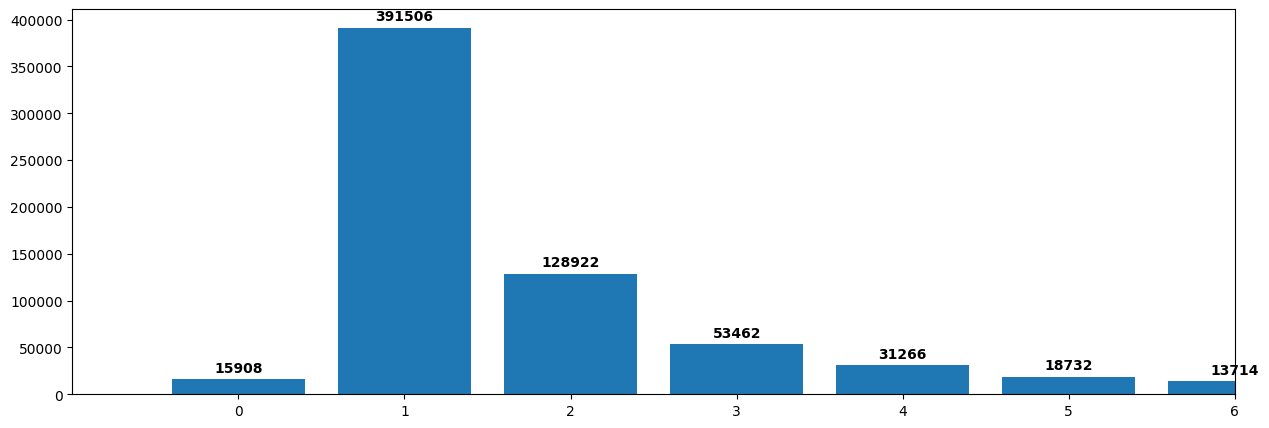

In [88]:
print(lims(airbnb_df['host_total_listings_count']))
box_diagram(airbnb_df['host_total_listings_count'])
bar_graph(airbnb_df['host_total_listings_count'])

### accommodates analysis
    -> The number of people the listing accommodates was not removed from analysis due to the fact that the model aims to predict the prices for any given size of property and the low number of outliers in this case. Furthermore, given the exclusion of high price listings before, these listings with a high number of people they can accommodate are probably not high end apartment/houses, which can still fit them in the generic people listings.

(-1, 9.5)


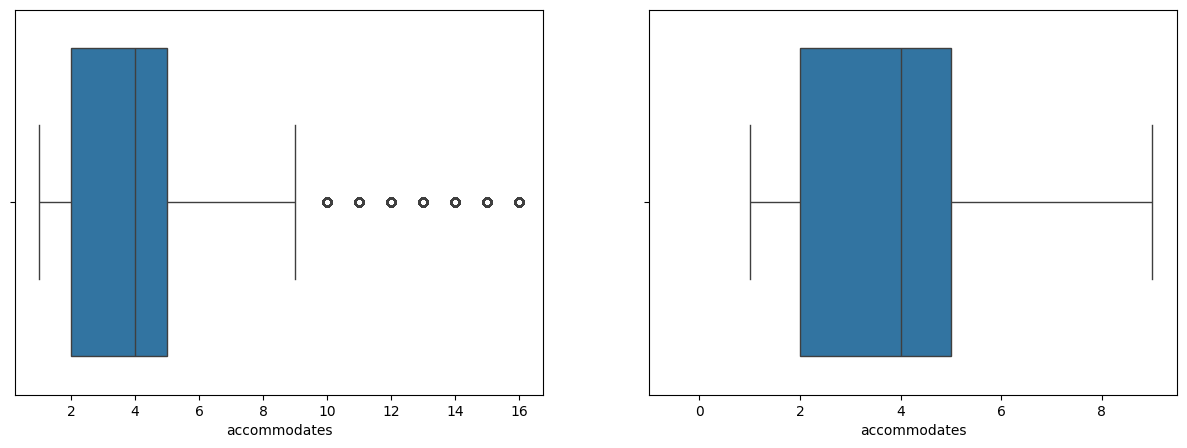

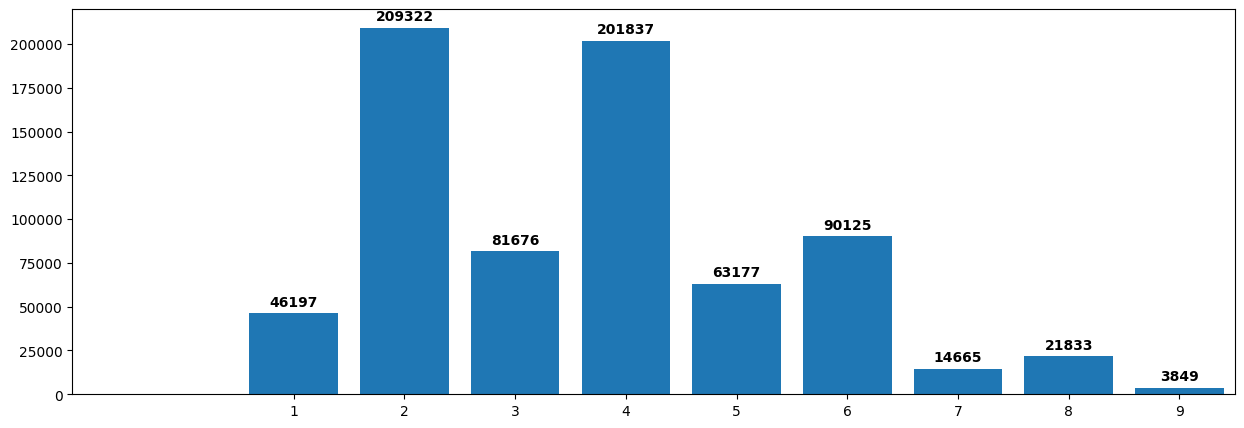

In [89]:
print(lims(airbnb_df['accommodates']))
box_diagram(airbnb_df['accommodates'])
bar_graph(airbnb_df['accommodates'])

### bathrooms analysis
    -> The number of bathrooms in the listing was not removed from analysis due to the fact that the model aims to predict the prices for any given size of property and the low number of outliers in this case.

(-1, 3.5)


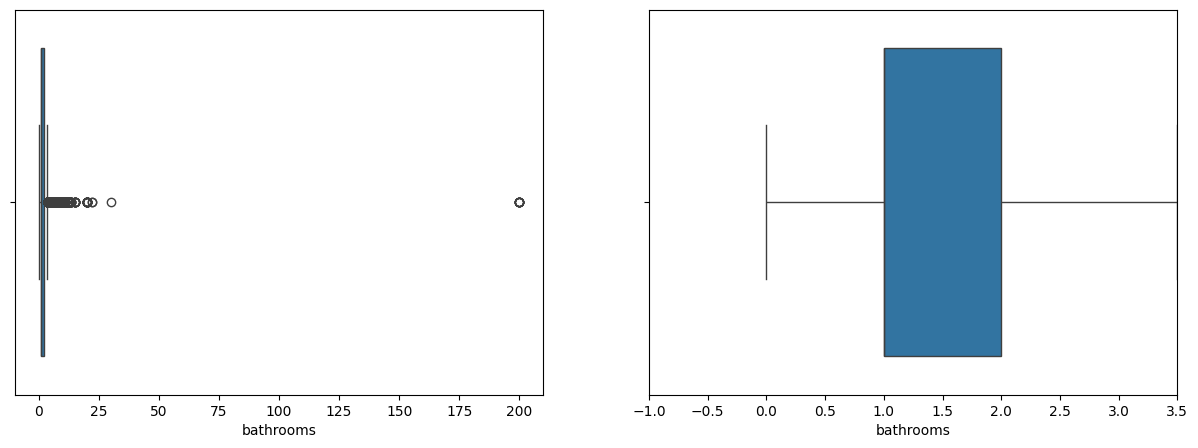

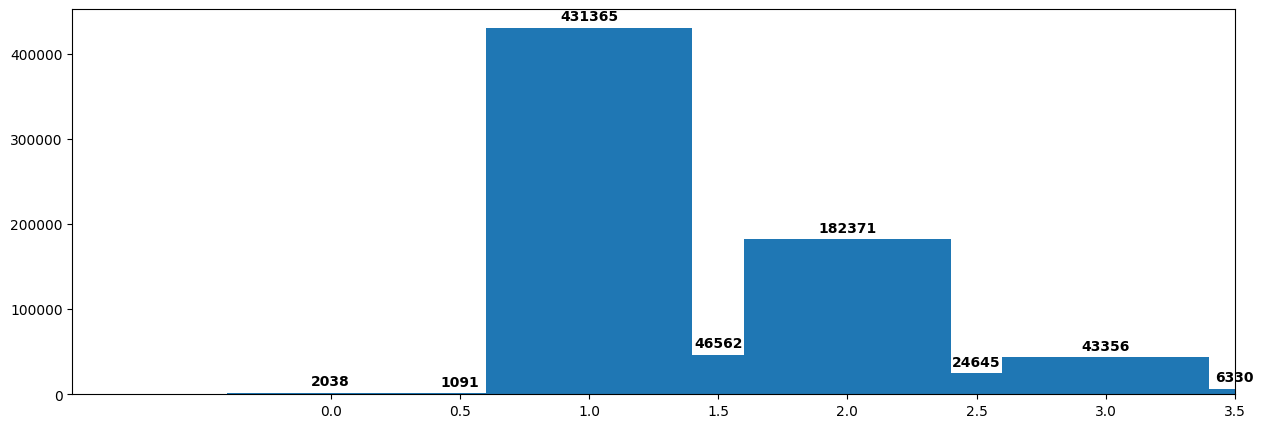

In [90]:
print(lims(airbnb_df['bathrooms']))
box_diagram(airbnb_df['bathrooms'])
bar_graph(airbnb_df['bathrooms'])

### bedrooms analysis
    -> The number of bedrooms in the listing was not removed from analysis due to the fact that the model aims to predict the prices for any given size of property and the low number of outliers in this case.

(-1, 3.5)


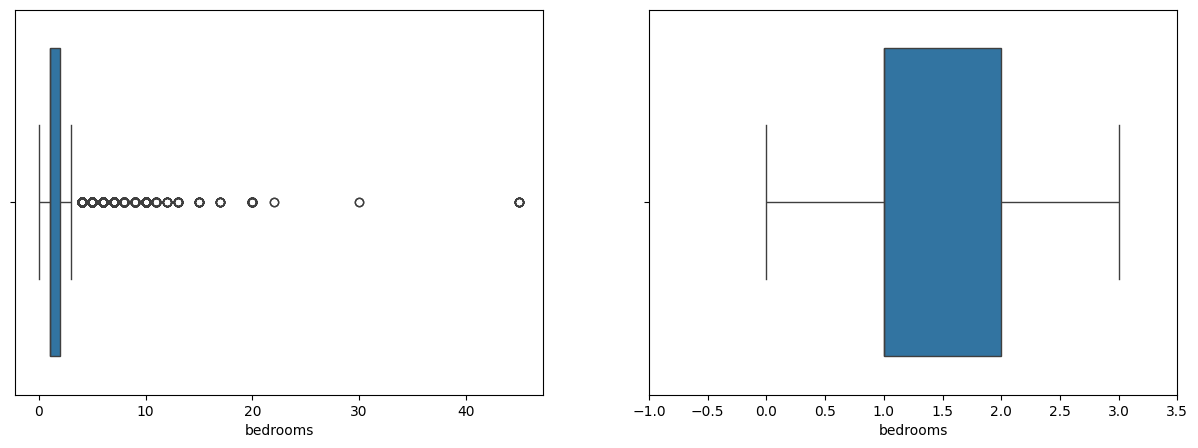

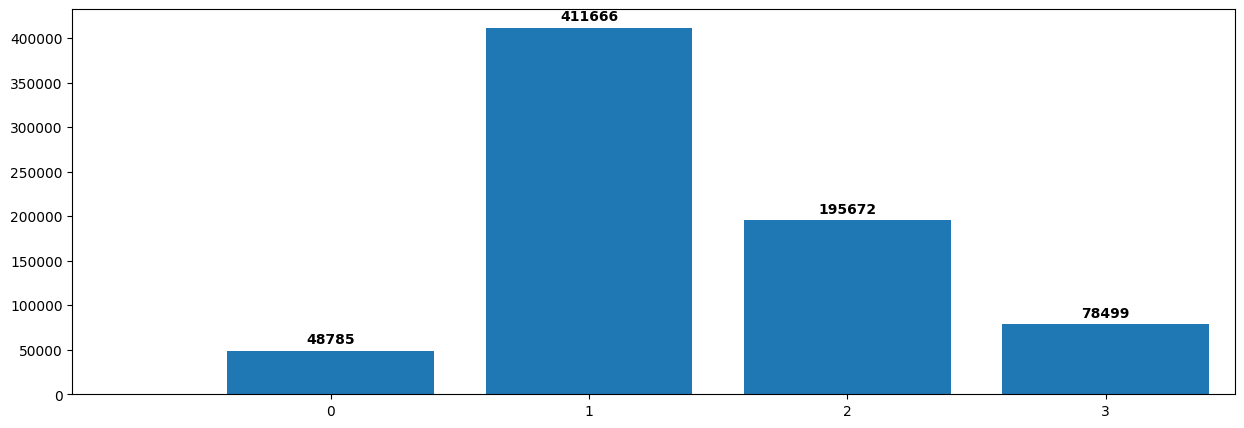

In [91]:
print(lims(airbnb_df['bedrooms']))
box_diagram(airbnb_df['bedrooms'])
bar_graph(airbnb_df['bedrooms'])

### beds analysis
    -> The number of beds in the listing was not removed from analysis due to the fact that the model aims to predict the prices for any given size of property and the low number of outliers in this case.

(-1, 6.0)


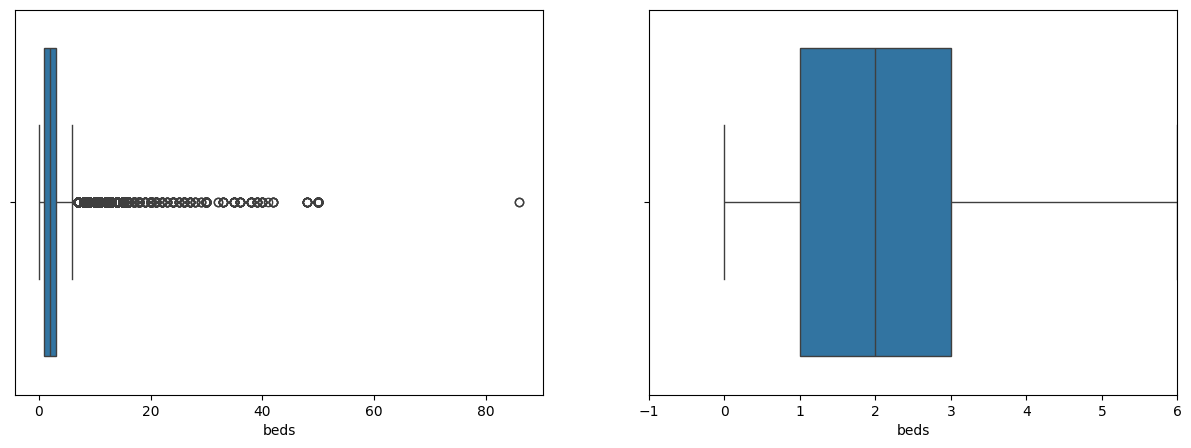

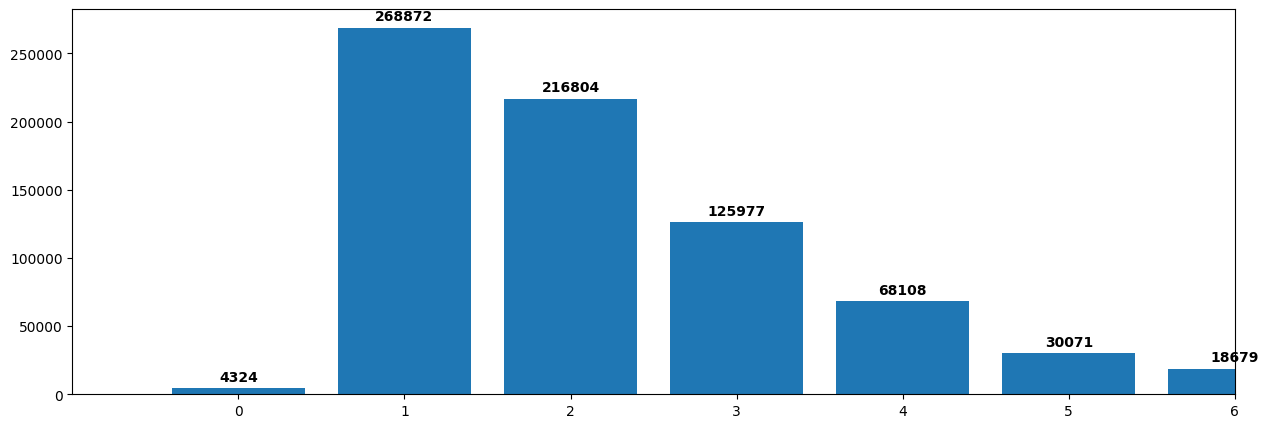

In [92]:
print(lims(airbnb_df['beds']))
box_diagram(airbnb_df['beds'])
bar_graph(airbnb_df['beds'])

### guests_included analysis
    -> As the guests_included has a high concentration in 1 guest included, it seems like it's a problem with the data presented. This feature may have been filled in wrongfully during the creating of the listings on the website, which can impact on the model in a bad way. For that reason, this column is removed from analysis.

(-1, 3.5)


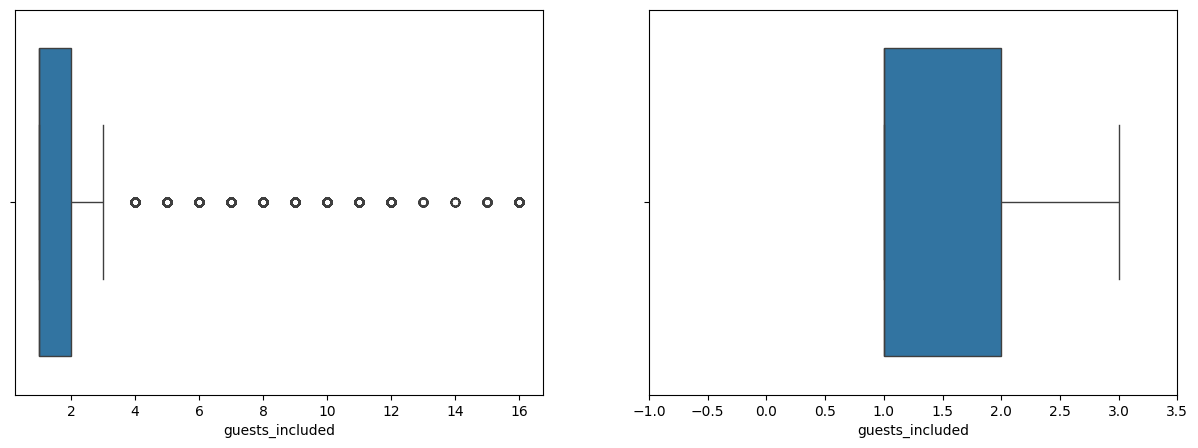

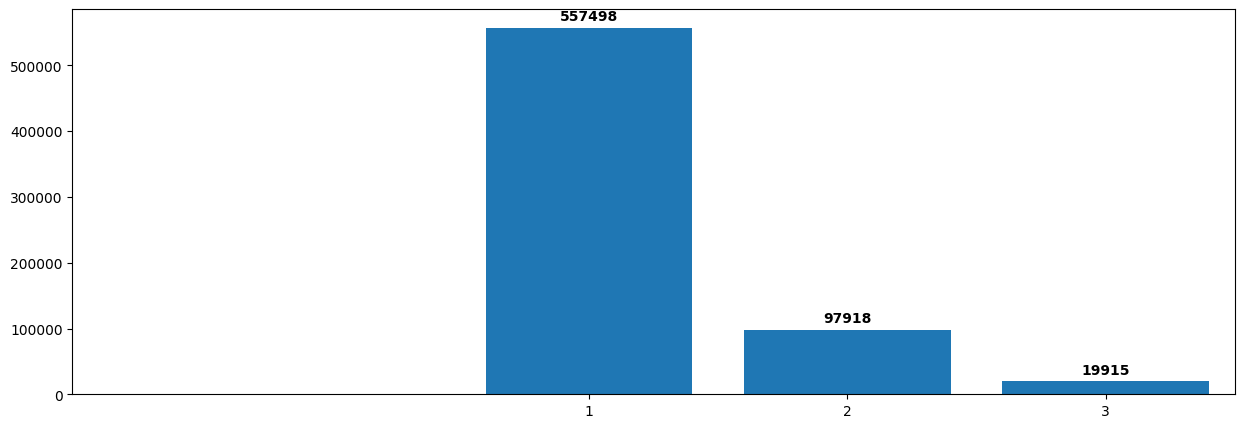

In [93]:
print(lims(airbnb_df['guests_included']))
box_diagram(airbnb_df['guests_included'])
bar_graph(airbnb_df['guests_included'])
airbnb_df = airbnb_df.drop('guests_included', axis = 1)

### minimum and maximum nights evaluation
    -> minimum nights were kept for the analysis due to the belief that this feature is probably more used during high season, when the accomodations tend to be more sought after due to factors such as holidays, and because the model aims to predict the price during specific times of the year. Given the fact that most of the data is within the limit estabilished, the outliers were removed for better precision of the model.
    -> On the other hand, maximum nights data is way too randomized for analysis so it was removed from the model.

(-1, 8.5)
45927
----------------------------------------
(-1, 2767.5)


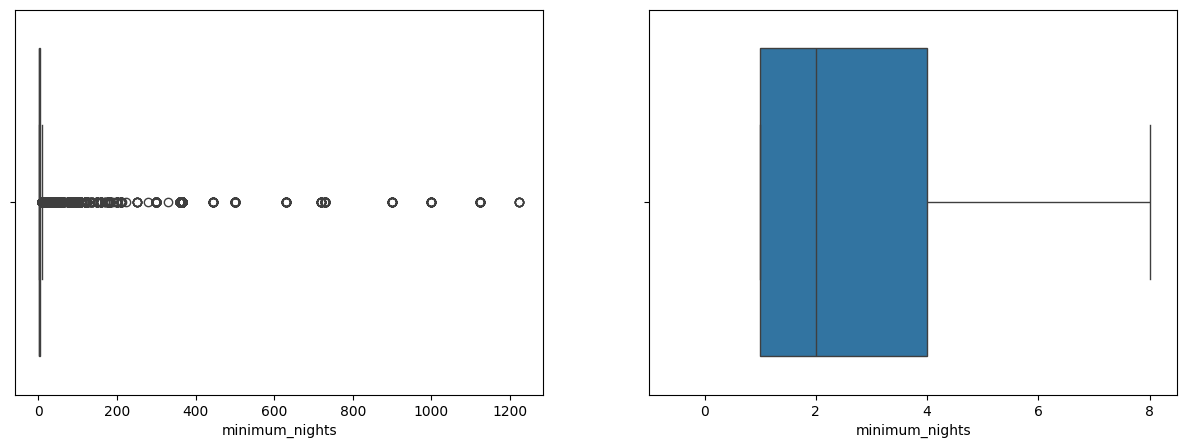

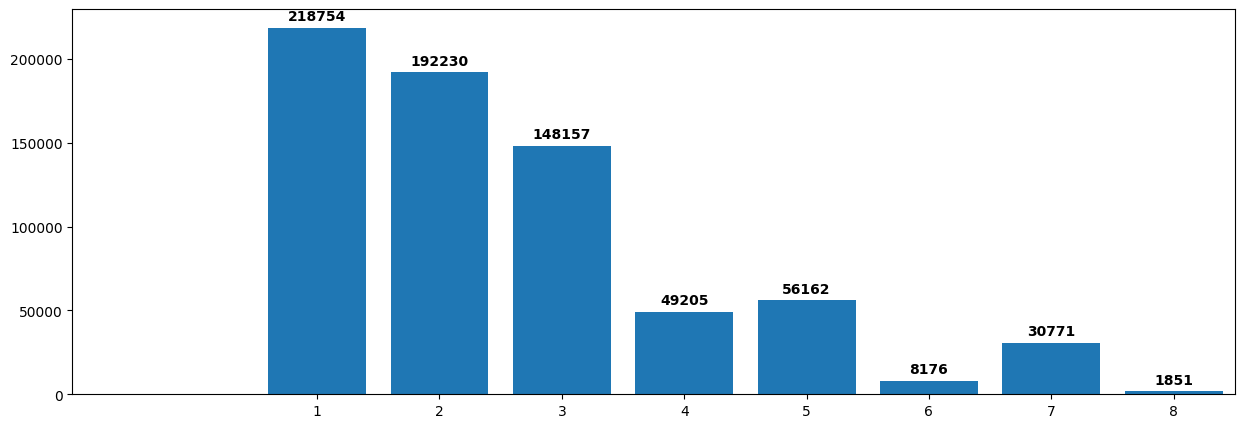

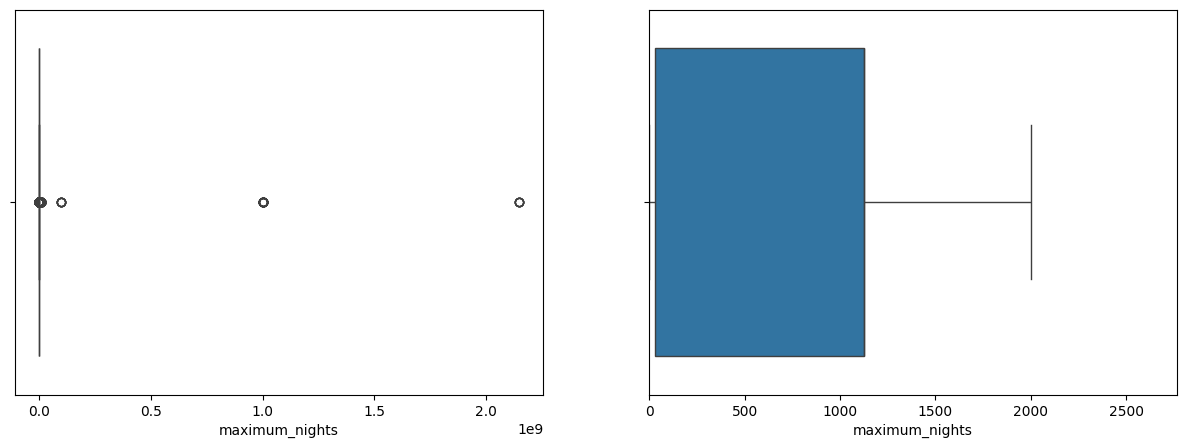

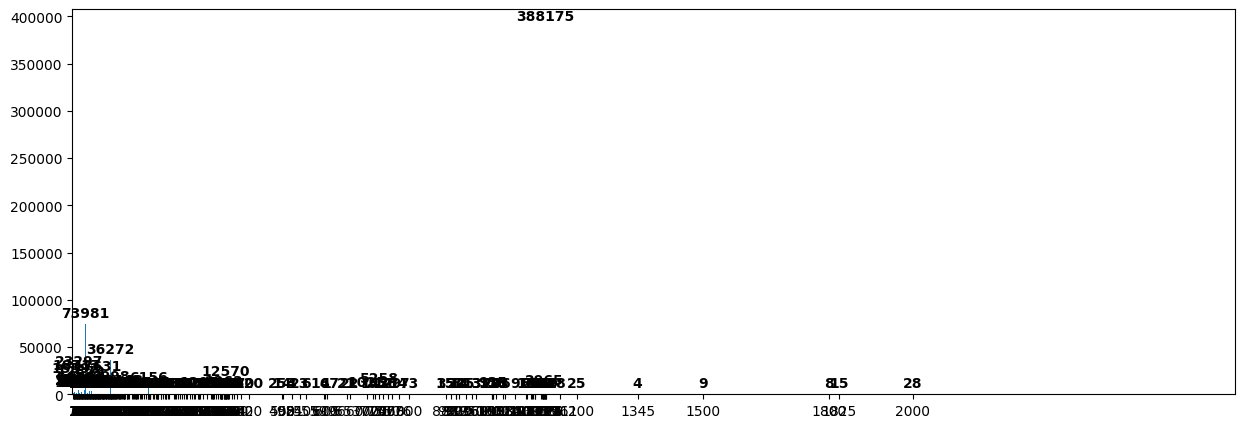

In [94]:
print(lims(airbnb_df['minimum_nights']))
box_diagram(airbnb_df['minimum_nights'])
bar_graph(airbnb_df['minimum_nights'])
airbnb_df, rows_removed = remove_outliers(airbnb_df, 'minimum_nights')
print(rows_removed)
print ('-' * 40)
print(lims(airbnb_df['maximum_nights']))
box_diagram(airbnb_df['maximum_nights'])
bar_graph(airbnb_df['maximum_nights'])
airbnb_df = airbnb_df.drop('maximum_nights', axis=1)

### number_of_reviews analysis
    -> The number of reviews outliers was not removed from the analysis given that it aims to identify the generic prices of accomodations given the time of the year in order for a generic person to book it. Accomodations with a high number of reviews may have been in the website for a longer time, giving the user the ability to identify if the listings are accordingly to the reality.

(-1, 15.0)


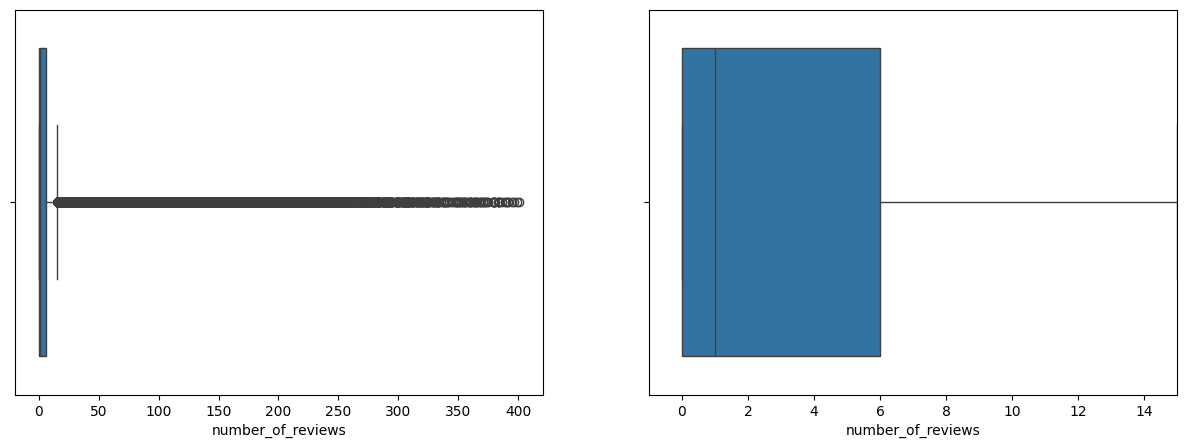

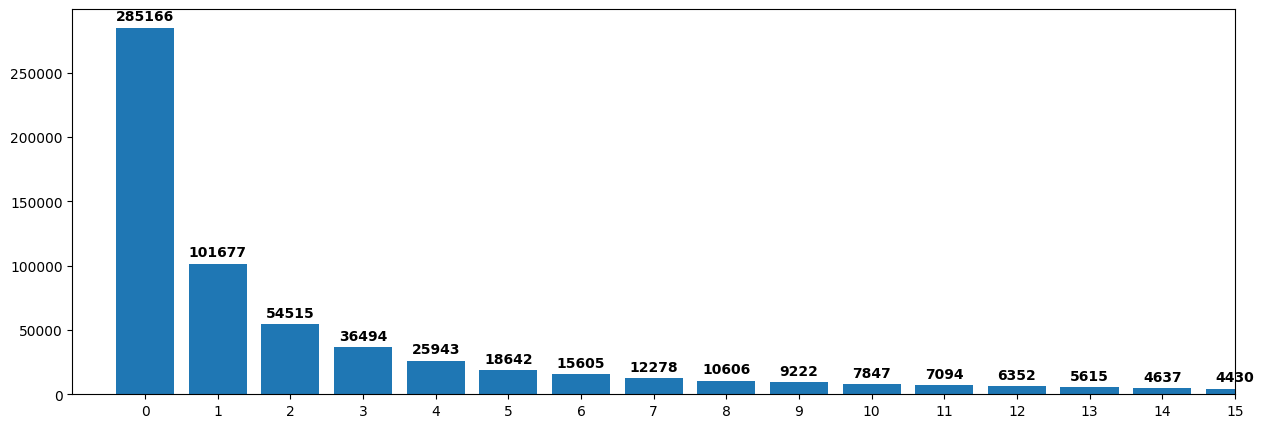

In [95]:
print(lims(airbnb_df['number_of_reviews']))
box_diagram(airbnb_df['number_of_reviews'])
bar_graph(airbnb_df['number_of_reviews'])

In [96]:
print(airbnb_df.shape)
print(airbnb_df.dtypes)
print(airbnb_df.iloc[0])

(705306, 24)
host_is_superhost                    object
host_total_listings_count             int32
host_identity_verified               object
latitude                            float32
longitude                           float32
property_type                        object
room_type                            object
accommodates                          int32
bathrooms                           float32
bedrooms                              int32
beds                                  int32
bed_type                             object
amenities                            object
price                               float32
extra_people                        float32
minimum_nights                        int32
number_of_reviews                     int32
instant_bookable                     object
is_business_travel_ready             object
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
year               

property_type                                                             Condominium

room_type                                                             Entire home/apt

bed_type                                                                     Real Bed

amenities                           {TV,"Cable TV",Internet,Wifi,"Air conditioning...

cancellation_policy                                                            strict

### property_type analysis
    -> As data was way to sparse in this column, all values after 'Other' were grouped in the 'Other' category to reduce the quantity of categories

property_type
Apartment                 546847
House                      65611
Condominium                32394
Serviced apartment         17345
Loft                       13439
Bed and breakfast           5822
Guest suite                 4272
Hostel                      4258
Guesthouse                  2721
Other                       2672
Villa                       1518
Aparthotel                  1312
Townhouse                   1211
Hotel                       1190
Boutique hotel               600
Earth house                  590
Chalet                       554
Cottage                      509
Tiny house                   498
Casa particular (Cuba)       349
Bungalow                     260
Cabin                        211
Dorm                         208
Nature lodge                 187
Castle                       150
Treehouse                     76
Island                        64
Boat                          58
Tent                          46
Farm stay                    

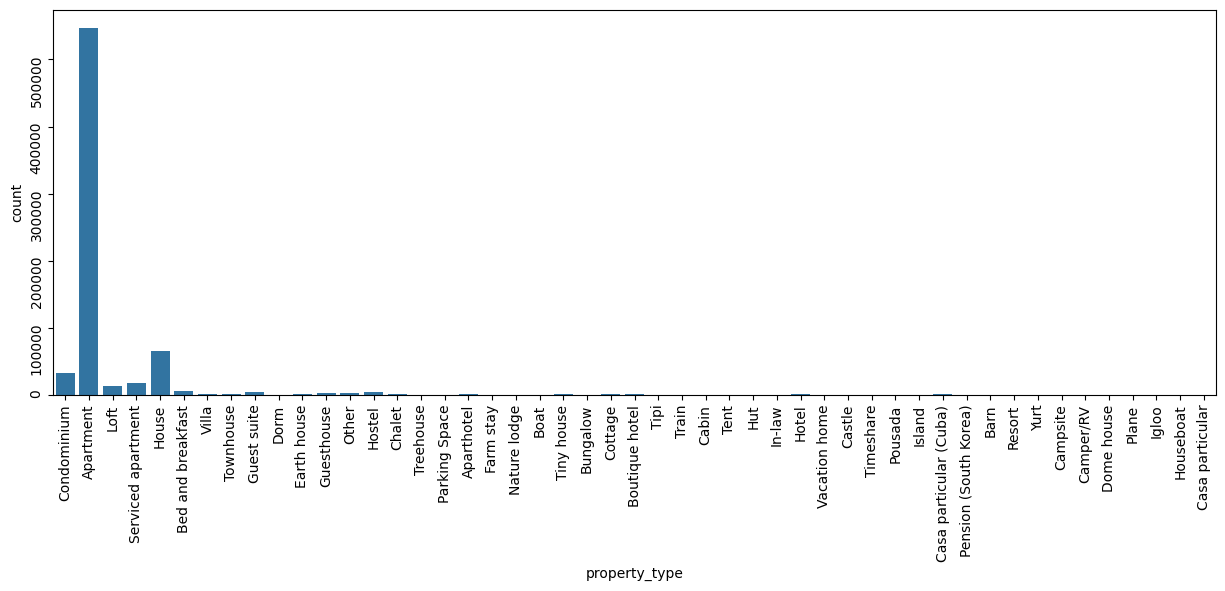

In [97]:
print(airbnb_df['property_type'].value_counts())

text_bar_graph('property_type')

property_type
Apartment             546847
House                  65611
Condominium            32394
Serviced apartment     17345
Loft                   13439
Other                  12597
Bed and breakfast       5822
Guest suite             4272
Hostel                  4258
Guesthouse              2721
Name: count, dtype: int64


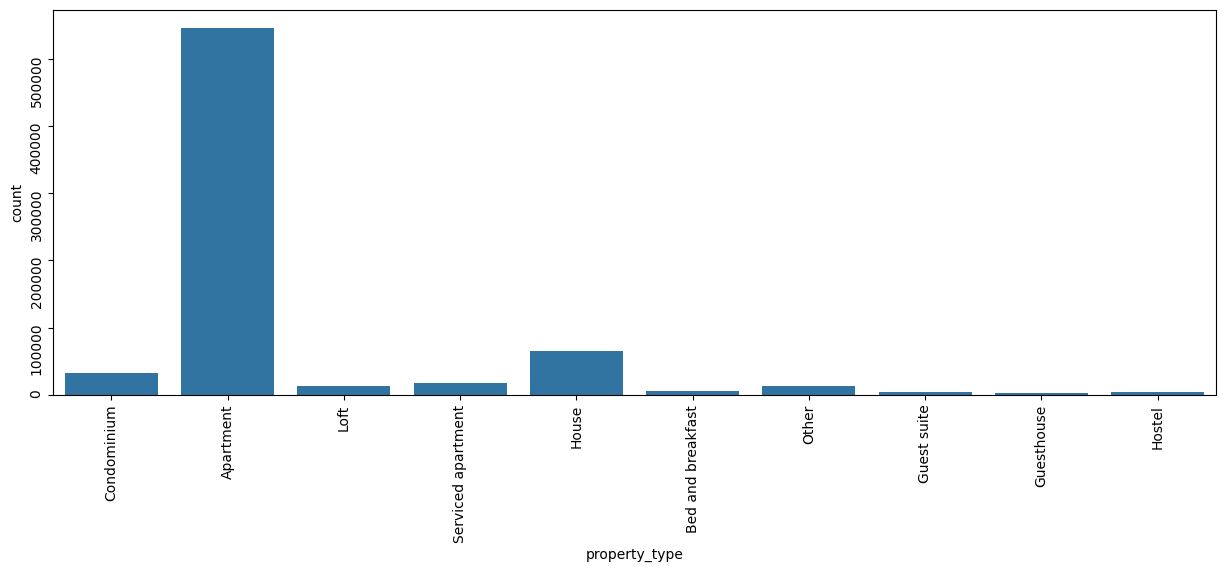

In [98]:
property_types = airbnb_df['property_type'].value_counts()
min_value = int((airbnb_df['property_type'] == 'Other').sum())
grouped_columns = []

for property_type in property_types.index:
    if property_types[property_type] < min_value:
        grouped_columns.append(property_type)
for type_removed in grouped_columns:
    airbnb_df.loc[airbnb_df['property_type'] == type_removed, 'property_type'] = 'Other'

print(airbnb_df['property_type'].value_counts())

text_bar_graph('property_type')

### room_type analysis
    -> As there are only a few categories for room types, no processing was done for this column

room_type
Entire home/apt    472448
Private room       213476
Shared room         17348
Hotel room           2034
Name: count, dtype: int64


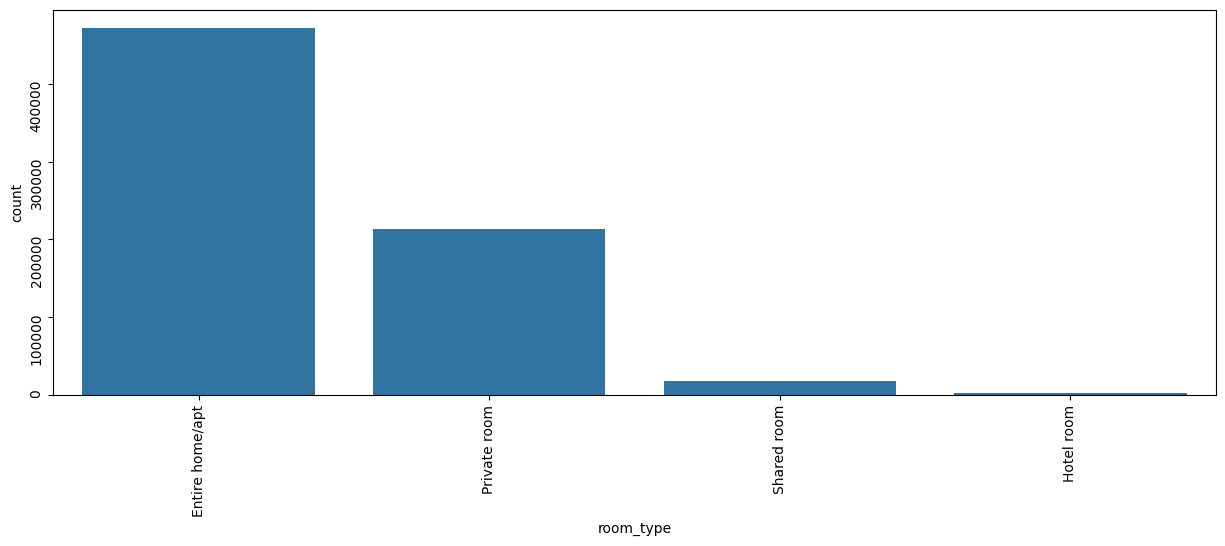

In [99]:
print(airbnb_df['room_type'].value_counts())
text_bar_graph('room_type')

### bed_type analysis
    -> As there are only a few categories for bed types, no processing was done for this column. Even though types other than 'Real Bed' are very low, for this model it's believed that this in an important feature while choosing which accomodation to book, so it was left unaltered.

bed_type
Real Bed         693294
Pull-out Sofa      8288
Futon              1862
Airbed             1294
Couch               568
Name: count, dtype: int64


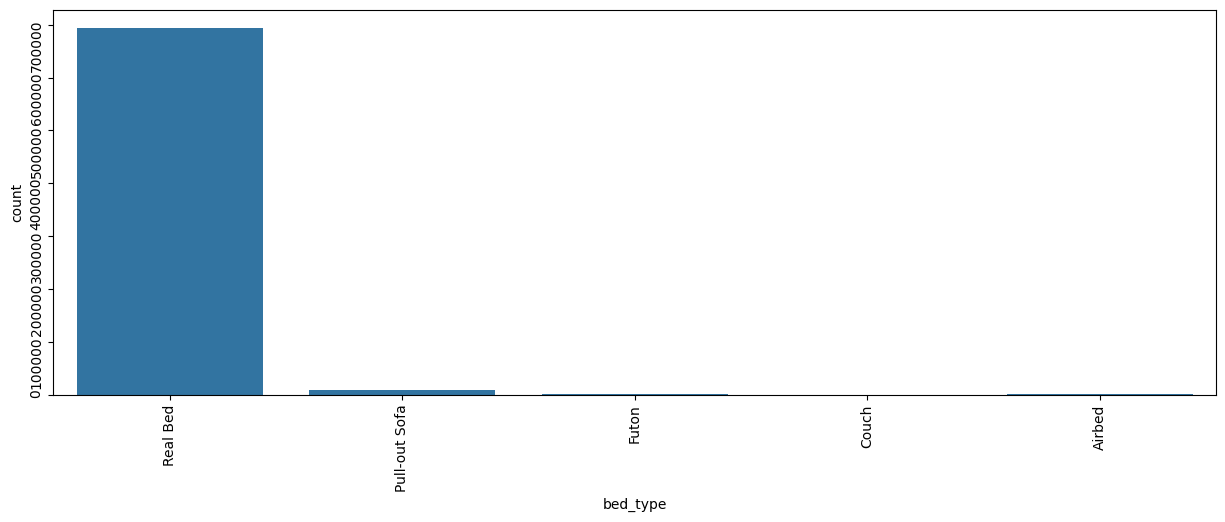

In [100]:
print(airbnb_df['bed_type'].value_counts())
text_bar_graph('bed_type')

### cancelation_policy analysis
    -> For this column, the different categories were grouped in three different categories to simplify the analysis: 'flexible', 'moderate', 'strict'. This was done due to the fact that there were more than one type of strict categories making the data spread in an unnecessary way. 

cancellation_policy
flexible                       292359
strict_14_with_grace_period    264522
moderate                       126266
strict                          13036
super_strict_60                  6514
super_strict_30                  2609
Name: count, dtype: int64
cancellation_policy
flexible    292359
strict      286681
moderate    126266
Name: count, dtype: int64


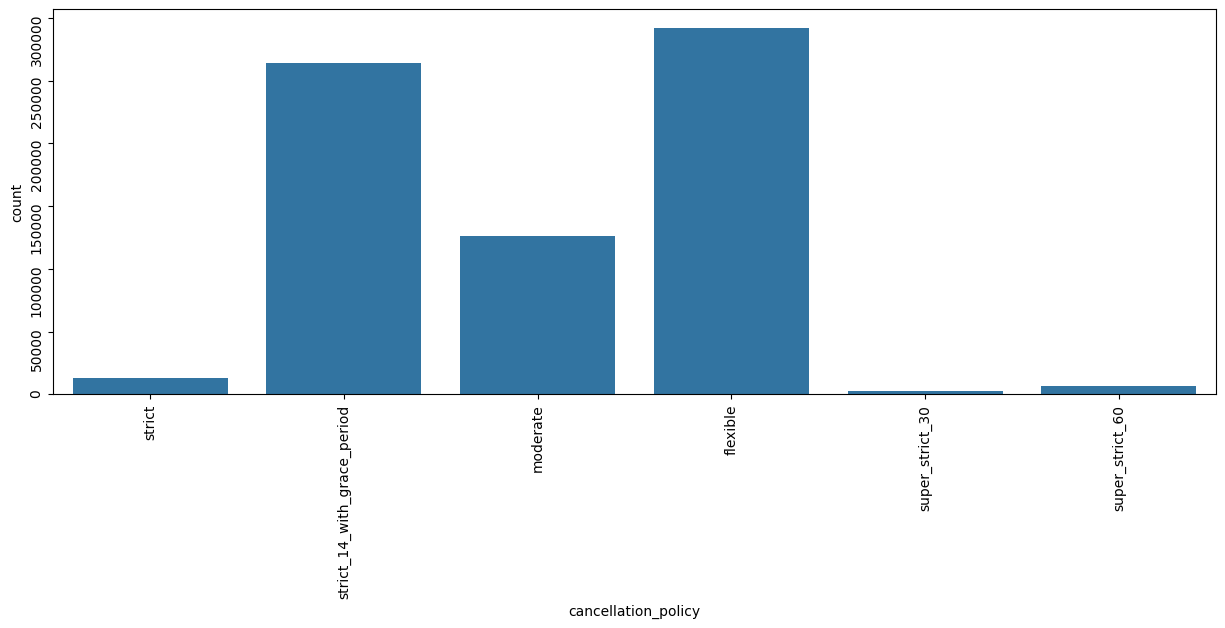

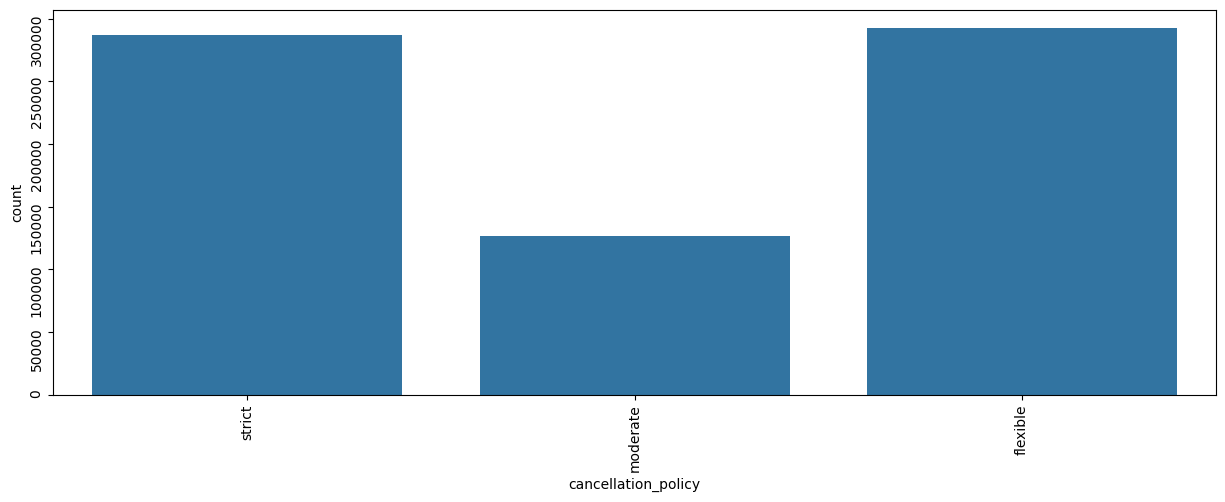

In [101]:
print(airbnb_df['cancellation_policy'].value_counts())
text_bar_graph('cancellation_policy')

cancellation_policys = airbnb_df['cancellation_policy'].value_counts()
cancellation_policys_kept = ['flexible', 'moderate', 'strict']
grouped_categories = []

for cancellation_policy in cancellation_policys.index:
    if cancellation_policy not in cancellation_policys_kept:
        grouped_categories.append(cancellation_policy)
for type_removed in grouped_categories:
    if 'flexible' in type_removed:
        airbnb_df.loc[airbnb_df['cancellation_policy'] == type_removed, 'cancellation_policy'] = 'flexible'
    if 'moderate' in type_removed:
        airbnb_df.loc[airbnb_df['cancellation_policy'] == type_removed, 'cancellation_policy'] = 'moderate'
    if 'strict' in type_removed:
        airbnb_df.loc[airbnb_df['cancellation_policy'] == type_removed, 'cancellation_policy'] = 'strict'

print(airbnb_df['cancellation_policy'].value_counts())

text_bar_graph('cancellation_policy')

### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo